# Tutorial - PyTorch Model for Speech Data

## Introduction

The objective of this tutorial is to give the reader an overview of speech data and to train a Convolutional Neural Network(CNN) on the given data. We will use a simple PyTorch model to predict the phoenmes of the data. Speech recognition is invading our lives. It’s built into our daily devices like phones, game consoles and smart watches. It’s even automating homes and other daily routines.

In this tutorial we will deal with speech data of the following order
> - Utterances are converted to "mel spectrograms", that is a pictorial representation that characterize how the frequency content of the signal varies with time. An utterance is a period of speech in which a user spells a sequence of text.
> - These utterances are of variable frame lengths, as length of utterance depends on length of text sequence.
> - Each frame consists of 40 bands of frequencies, where each frequency is a single floating value. 100 frames form one second of speech
> - The phonemes are labelled on an order of varying frame lengths, these lengths are given as input along with utterance data.

### Content

In this tutorial, we will see some common analysis in Python, specifically using [PyTorch](http://pytorch.org/).

We'll be using data generated out of audio files with common sequences of text. More about generation of data can be found at [Speech-Processing for ML](http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html). The data used here is similar to source's mean numpy array which contains 40 dimension frequency bands. While speech data is represented in multiple forms, our representation is widely used in speech processing for Machine Learning Algorithms.

We will breif over the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Loading data and plotting](#Loading-data-and-plotting)
- [Data preprocessing](#Data-preprocessing)
- [Building model](#Building-model)
- [Model Training](#Model-Training)
- [Predicting for test data](#Predicting-for-test-data)
- [Additional features](#Additional-features)
- [References](#References)

## Installing the libraries

Preferably install the required pacakges into an environment. A sample set of installation commands are given below for OSX and conda environment. Use [PyTorch](http://pytorch.org/) to install from binaries via `conda` or `pip` wheels -

```python
conda create -n pytorch python=3.6 matplotlib jupyter scikit-learn numpy anaconda --yes
source activate pytorch
conda install pytorch torchvision -c pytorch --yes
```

The above will create an environment `pytorch` in conda with the other packages mentioned, and installs PyTorch within this environment. Please note that the PyTorch version used in this notebook is `0.3.0.post4`. You can verify your version by running `torch.__version__`

Running the cell below without any errors should be a good indication that all requirements are satisfied.

In [1]:
# Torch Imports
import torch
import torch.nn as nn

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.nn.init import _calculate_fan_in_and_fan_out

# SciKit Learn Imports for Data Preprocessing
from sklearn.preprocessing import OneHotEncoder

# Future Imports
from __future__ import absolute_import, division, print_function

# General Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

In [2]:
# Set the plot graph figure size to 20 inches, 4 inches (width, height)
pltWidth, pltHeight = 20, 4
plt.rcParams['figure.figsize'] = (pltWidth, pltHeight)

## Loading data and plotting

Our data consists of utterances of text sequences. These utterances are made of mel spectrogram frames. Our labels are phonemes belonging to the following 

> `["+BREATH+", "+COUGH+", "+NOISE+", "+SMACK+", "+UH+", "+UM+", "AA", "AE", "AH", "AO", "AW", "AY", "B", "CH", "D", "DH", "EH", "ER", "EY", "F", "G", "HH", "IH", "IY", "JH", "K", "L", "M", "N", "NG", "OW", "OY", "P", "R", "S", "SH", "SIL", "T", "TH", "UH", "UW", "V", "W", "Y", "Z", "ZH"]`

Based on the speaker, the time for each phoneme varies, hence each label is linked to multiple input frames. The data for the timestamp of each phoneme label is also given to us as input. Our task is to predict the label for a given utterance, and their corresponding phoneme timestamps.

First we will split our data into train, dev and test sets by randomly selecting a percentage of indices from the length of our input features. We then select the features and labels corresponding to these indices from the dataset and partition them into three files of train, dev and test.

We will then overload the abstract `Dataset` class from torch, which allows us to load our data into class variables and hence generate the spectrogram frequencies, labels and timestamps for a given index when required using the `__getitem__()` function. In addition, we also have to overload the `__len__()` function which will return the number of utterances in our data.

In [3]:
phonemeList = ["+BREATH+", "+COUGH+", "+NOISE+", "+SMACK+", "+UH+", "+UM+", "AA", "AE", "AH", "AO", "AW",
               "AY", "B", "CH", "D", "DH", "EH", "ER", "EY", "F", "G", "HH", "IH", "IY", "JH", "K", "L",
               "M", "N", "NG", "OW", "OY", "P", "R", "S", "SH", "SIL", "T", "TH", "UH", "UW", "V", "W",
               "Y", "Z", "ZH"]

In [4]:
def partitionDataset(featureFilename, labelFilename, train=70, dev=20):
    """
    Split the data available into train, test and dev datasets
    Args:
        featureFilename (str): filename containing numpy array of features
        labelFilename (str): filename containing numpy array of labels
        train (int): percentage of the data to be used for training set
        dev (int): percentage of the data to be used for dev set
    Returns:
        None
    """
    features = np.load(featureFilename, encoding='bytes')
    labels = np.load(labelFilename, encoding='bytes')
    
    featureLen = len(features)
    allIndicesArray = np.arange(featureLen)
    trainIndices = np.random.choice(allIndicesArray, int(featureLen*train/100), replace=False)
    
    unselectedIndices = np.setdiff1d(allIndicesArray, trainIndices)
    devIndices = np.random.choice(unselectedIndices, int(featureLen*dev/100), replace=False)
    testIndices = np.setdiff1d(unselectedIndices, devIndices)
    
    trainFeatures, trainLabels = features[trainIndices], labels[trainIndices]
    devFeatures, devLabels = features[devIndices], labels[devIndices]
    testFeatures, testLabels = features[testIndices], labels[testIndices]
    
    np.save('Data/train-features.npy', trainFeatures)
    np.save('Data/train-labels.npy', trainLabels)
    np.save('Data/dev-features.npy', devFeatures)
    np.save('Data/dev-labels.npy', devLabels)
    np.save('Data/test-features.npy', testFeatures)
    np.save('Data/test-labels.npy', testLabels)
    
    print('Data has been partitioned into train:{}%, dev:{}% and test:{}%'.format(train, dev, 100-train-dev))

In [5]:
partitionDataset('Data/features.npy', 'Data/labels.npy')

Data has been partitioned into train:70%, dev:20% and test:10%


In [6]:
class speechDataset(Dataset):
    def __init__(self, featureFilename, labelFilename):
        """
        Args:
            featureFilename (string): Path to the _dataset-feature_.npy file.
            labelFilename (string): Path to the _dataset-labels_.npy file.
        Returns:
            None
        """
        # Load features, labels and timestamps
        self.featureValues = np.load(featureFilename, encoding="bytes")
        self.featureLabels = np.load(labelFilename, encoding="bytes")
        self.featureTmstmp = self.featureValues[:, 1]
        self.featureValues = self.featureValues[:, 0]
    
    def __len__(self):
        """
        Args:
            None
        Returns:
            int: length of the dataset - number of utterances
        """
        return len(self.featureValues)
    
    def __getitem__(self, index):
        """
        Args:
            index (int): The index of utterance to be returned
        Returns:
            FloatTensor: The (40, numFrame) utterance the index points to
            IntTensor: The timestamps of the labels for the utterance selected by index
            IntTensor: The labels for the utterance selected by index
        """
        featureValue = torch.FloatTensor(self.featureValues[index])
        featureLabel = torch.IntTensor(self.featureLabels[index])
        return featureValue, self.featureTmstmp[index], featureLabel
    
    def standardizeData(self):
        """
        Standardize the data by (x - mean)/variance over each frequency band
        Args & Return:
            None & None
        """
        runningSum = np.zeros(40)
        runningSquareSum = np.zeros(40)
        numFrames = 0
        
        for index in range(self.__len__()):
            runningSum += np.sum(self.featureValues[index], axis=0)
            runningSquareSum += np.sum(np.square(self.featureValues[index]), axis=0)
            numFrames += self.featureValues[index].shape[0]
        
        frequencyBandMean = runningSum/numFrames
        frequencyBandVar = runningSquareSum/numFrames - np.square(frequencyBandMean)
        
        for index in range(self.__len__()):
            standardizeNumerator = (self.featureValues[index] - frequencyBandMean)
            standardizeValue = (standardizeNumerator/frequencyBandVar).transpose()
            self.featureValues[index] = standardizeValue

In [7]:
trainUtterances = speechDataset('Data/train-features.npy', 'Data/train-labels.npy')
devUtterances = speechDataset('Data/dev-features.npy', 'Data/dev-labels.npy')
testUtterances = speechDataset('Data/test-features.npy', 'Data/test-labels.npy')

Generate a random index and select the mel spectrogram frames from the data. We will use these to generate two plots -
> - Amplitude of each frequency band vs time in seconds.
> - Mean amplitude of all frequency band vs time in seconds.

Our data frames are 25ms wide, where stride between adjacent frames is about 10ms. Thus the number of frames per second of speech is `frameRate=100`.

In [8]:
numUtterances = trainUtterances.__len__()
randomIndex = np.random.randint(numUtterances)

frequencyBands, timestamps, labels = trainUtterances.__getitem__(randomIndex)

# Put the data into a numpy array with the dimensions in (numFrames, numBands)
frequencyBands = frequencyBands.numpy()

numFrames = frequencyBands.shape[0]
frameRate = 100

# Calculate the time period for each frame of data
Time = np.linspace(0, numFrames/frameRate, num=numFrames)

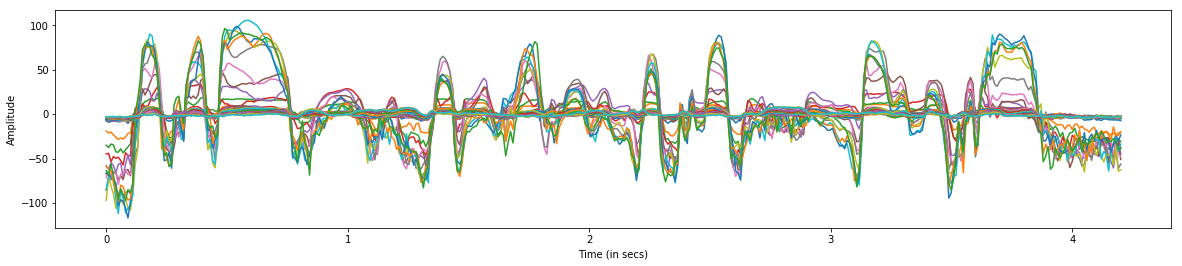

In [9]:
plt.plot(Time, frequencyBands)
plt.xlabel('Time (in secs)')
plt.ylabel('Amplitude')
plt.show()

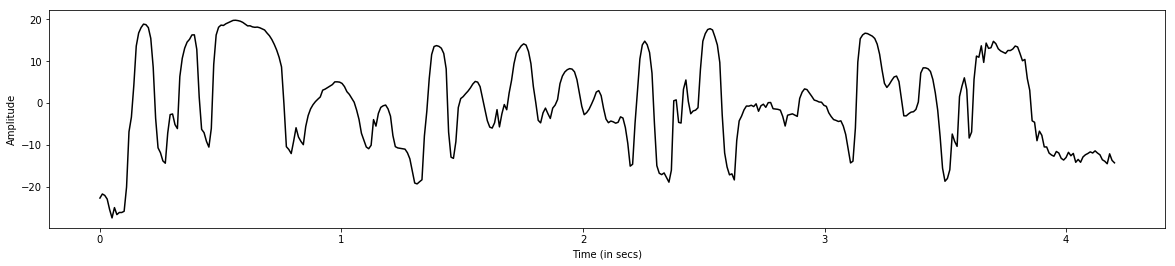

In [10]:
plt.plot(Time, np.mean(frequencyBands, axis=1), color='k')
plt.xlabel('Time (in secs)')
plt.ylabel('Amplitude')
plt.show()

## Data preprocessing

Our first data preprocessing step will be to standardize the data. Standardization is given by
<center>
    $$$$
    $$X = \frac{X - \mu}{\sigma^2}$$
</center>
where, mean can be calculated as
<center>
    $$$$
    $$\mu = \frac{\sum X}{N}$$
</center>
and, variance can be calculated as
<center>
    $$$$
    $$\sigma^2 = \frac{\sum{X-\mu}^2}{N} = \frac{\sum X^2}{N} - \mu^2$$
</center>

Here, `X` is the 40 band frequency data and `N` is the number of frames over all frames of each utterance. We shall now see the data plots after the standardization has been done below.

In [11]:
trainUtterances.standardizeData()
devUtterances.standardizeData()
testUtterances.standardizeData()

In [12]:
# For the same random index used for previous generation of data plot, get the new standardized data
frequencyBands, timestamps, labels = trainUtterances.__getitem__(randomIndex)
frequencyBands = frequencyBands.numpy().transpose()

# Calculate the time period for each frame of data
Time = np.linspace(0, numFrames/frameRate, num=numFrames)

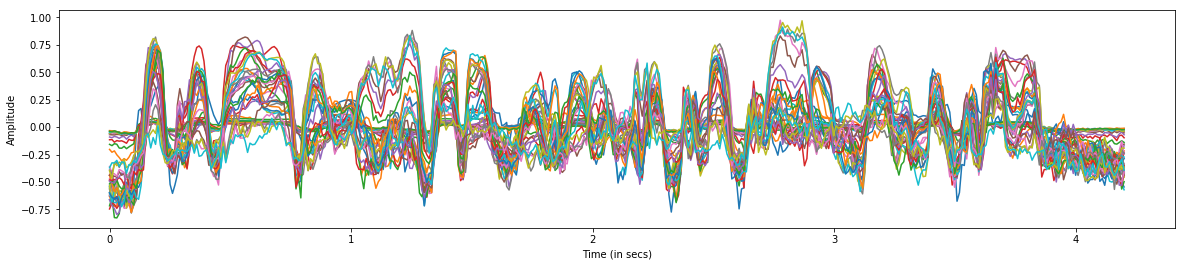

In [13]:
plt.plot(Time, frequencyBands)
plt.xlabel('Time (in secs)')
plt.ylabel('Amplitude')
plt.show()

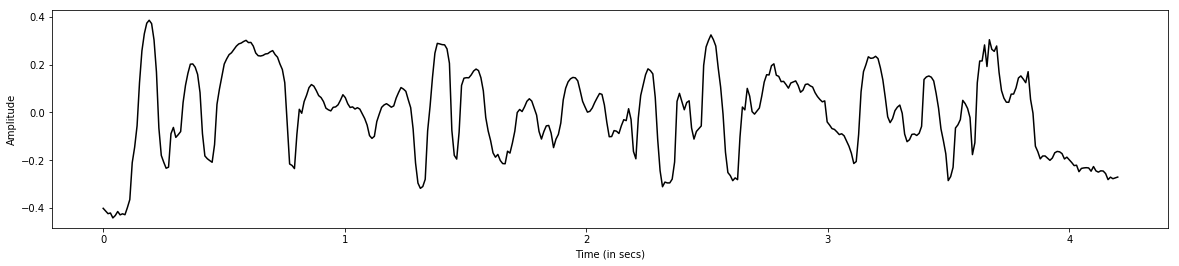

In [14]:
plt.plot(Time, np.mean(frequencyBands, axis=1), color='k')
plt.xlabel('Time (in secs)')
plt.ylabel('Amplitude')
plt.show()

Our input data has variable length utterances. All models require the data with a fixed shape as input. Since we are going to apply Convolutional Layers and follow them with Linear layers, we will transform our data to the required format.

For the Convolutional-1D layer, the data needs to be of `(N, C, L)` dimensions, where `N` is the batchSize, `C` is the numChannels and `L` is the Length of Signal Sequence(varies with each batch). 

`C` and `N` are constant throughout the execution of a given training period. `C` depicts the number of filters to learn during the training period of our model. These filters will help bring out the important features of our data when the model has been trained.

The output of the CNN will be input to the linear layers. The linear layers expect a single hidden dimension parameter. Hence, we average our CNN output over the phoneme boundary of each utterance. To average over the phoneme boundary, we require a mask that can correctly identify the boundaries of the phoneme in each utterance of the batch.

First we are going to apply a Conv1D layer, for which we will batch utterances by concatenating them one after another. For this, we require our data to be a constant by the rows, hence we transpose the input data to `(40, numFrames)` shape, and then concatenate multiple utterances over the first dimension of 40 frequency bands. Performing a simple concatenation will make our CNN to apply its filters over the ends of the utterance and hence corrupting data. Hence, we pad by adding enough `0` vectors of `(40, paddingLen)` shape before concatenating the next utterance. At the end of concatenation, our `inputVector` is of the shape `(1, 40, sumFrameLengths + sumPaddingLengths)`. The 1 is present because we have batched all data into one vector.

Now, the output of the CNN will give us `(1, outChannel, sumFrameLengths + sumPaddingLengths)` which corresponds to the 46 possible phoneme labels. Since we have to average over the phoneme boundaries, we cannot allow the Signal Sequence length to be clipped off during the CNN pass, hence we apply padding and stride hyperparameters to the layers accordingly.

The averaging over the Sequence length is done by averaging each phoneme according to the number of frames it corresponds to. To do so, we create an assignment vector, which is a single dimensional vector that numbers each frame sequentially with respect to the phoneme boundary. So in case we have a batch with two utterances - `[u0, u1]` as input. Let us assume that `u0` has 6 frames such that first 4 frames correspond to the first phoneme and the next 2 frames correspond to the second phoneme. Similarly, `u1` has 5 frames with 2 frames for first phoneme, 1 for second phoneme and 2 for third phoneme. Also, let us assume we have `paddingValue=2`. Now our input is of the form `[u0f0, u0f1, u0f2, u0f3, u0f4, u0f5, pad, pad, u1f0, u1f1, u1f2, u1f3, u1f4, pad, pad]`, which correspond to phonemes `[u0p0, u0p1, pad, u1p0, u0p1, u0p2, pad]` with phoneme timestamps `[4, 2, 2, 2, 1, 2, 2]`. For this we will create a assignment vector with paddings having a `0` value and other phonemes having a sequential assignment value as follows `[1, 1, 1, 1, 2, 2, 0, 0, 3, 3, 4, 5, 5, 0, 0]`. Based out of this assignment vector we will make a mask by oneHotEncoding the assignment vector and dividing by the phoneme lengths accordingly.

This mask will be applied to each channel outputted by the CNN and will convert the output to the shape `(outChannel, numPhonemes)` which we will transpose and pass to the linear layers that will fit the data into the required output dimension. The final layer will be of the form `(numPhonemes, 46)` which we will use to predict the phoneme label by applying argmax over the last dimension.

In [15]:
def createRelativeAssignments(tmstmpList, counter=1):
    """
    Genrate the relative assignment vector based on the phoneme location in the utterance
    Args:
        tmstmpList (list): start positions of each phoneme within a utterance
        counter (int): phoneme start count with respect to the batch until current utterance.
                       First utterance starts the phoneme count with 1
    Returns:
        assignments (list): contains the relative phoneme counts for the frames of the given utterance.
    """
    assignments = []
    for i in range(1, len(tmstmpList)):
        assignments.extend([counter]*(tmstmpList[i]-tmstmpList[i-1]))
        counter += 1
    return assignments


def oneHotEncode(assignmentVector):
    """
    Convert assignment vector to its OneHotEncoded form and average by number of frames in the Phoneme
    Args:
        assignmentVector (list): 1D Array of assignments of the phoneme count for a given batch of data
    Returns:
        maskMatrix (FloatTensor): OneHotEncoded mask, averaged over the frames in the phoneme
    """
    encodedAssignment, onehotEncoder = np.array(assignmentVector), OneHotEncoder(sparse=False)
    encodedAssignment = encodedAssignment.reshape(len(encodedAssignment), 1)
    
    # Make a mask matrix and remove the column corresponding to padding(0)
    maskMatrix = np.array(onehotEncoder.fit_transform(encodedAssignment))[:,1:]
    
    # Weight the OneHotEncoded matrix according to the number of frames in the Phoneme
    paramVector = [1/assignmentVector.count(x) for x in assignmentVector]
    maskMatrix = np.array([paramVector]).transpose()*maskMatrix
    
    return Variable(torch.FloatTensor(maskMatrix))


def customCollate(batch, padding=2):
    """
    Overloaded collate_fn for a data loader
    Args:
        batch (list(tuple)): [(X, tmstmp, label), ...] of length batchSize
    Returns:
        batchInput (FloatTensor): Padded input of batch feature values of (1, 40, sumFrameLengths + sumPadLengths)
        maskMatrix (FloatTensor): mask as generated by oneHotEncode()
        labels (IntTensor): 1D tensor of labels in a consecutive fashion
    """
    featureVectors, timestamps, labels = zip(*batch)
    
    batchedInput, assignmentVector = None, []
    labelVector = torch.cat(labels)
    
    # Paddings to be applied for assignment vector and input vector
    assignmentPadding, featurePadding = [0]*padding, torch.zeros((40, padding))
    
    for feature, tmstmpList in zip(featureVectors, timestamps):
        # Generate the assignment vector that later generates the one-hot matrix for the batch
        tmstmpList = np.append(tmstmpList, len(feature[0]))
        if assignmentVector:
            assignmentVector.extend(createRelativeAssignments(tmstmpList, max(assignmentVector)+1))
        else:
            assignmentVector.extend(createRelativeAssignments(tmstmpList))
        assignmentVector.extend(assignmentPadding)
        
        # Generate the feature vector
        batchedInput = torch.cat([batchedInput, feature], dim=1) if batchedInput is not None else feature
        batchedInput = torch.cat([batchedInput, featurePadding], dim=1)
    
    # Return torch tensors for feature vectors, OneHotEncoded Matrix and feature labels of the given batch
    return Variable(batchedInput.view(1, 40, -1)), oneHotEncode(assignmentVector), Variable(labelVector)

## Building model

We will now see a simple model with a few CNN layers, as mentioned earlier which are followed by set of linear layers before taking the cross entropy loss and predicting output labels. We will define a class that inherits from the `nn.Module` of torch and define all model parameters within this class. We will use the following specifications - 
> 1. Initialize criterion or loss evaluation with a CrossEntropyLoss module
> 2. Initialize optimizer with Adam and set `learningRate=1e-2` and `weightDecay=1e-6`
> 3. Define 3 conv1D layers to apply on the input sequentially
> 4. Define 2 linear layers
> 5. For each of the CNN and Linear layer define a BatchNorm1d layer and ReLU activation
> 6. Have a linear layer for softmax activation input
> 7. Initialize weights of linear and convolutional layers with xavier intialization

In [16]:
class CNNModelSpeechData(nn.Module):
    def __init__(self, args):
        """
        Define model architecture and initialize other parameters required for model's functioning
        Args:
            args (object): class with all constant entities for the model
        Returns:
            None
        """
        super(CNNModelSpeechData, self).__init__()
        self.numPhonemes = args.numPhonemes
        
        self.modelList = nn.ModuleList([
            nn.Conv1d(in_channels=args.inChannels, out_channels=args.hiddenChannels, kernel_size=3,
                      padding=1, stride=1, bias=True),
            nn.BatchNorm1d(args.hiddenChannels),
            nn.ReLU(),
            
            nn.Conv1d(in_channels=args.hiddenChannels, out_channels=args.hiddenChannels, kernel_size=3,
                      padding=1, stride=1, bias=True),
            nn.BatchNorm1d(args.hiddenChannels),
            nn.ReLU(),
            
            nn.Conv1d(in_channels=args.hiddenChannels, out_channels=args.outputDim, kernel_size=3,
                      padding=1, stride=1, bias=True),
            nn.BatchNorm1d(args.outputDim),
            nn.ReLU()])
        
        self.maskedModelList = nn.ModuleList([
            nn.Linear(args.outputDim, args.hiddenDim[0]),
            nn.BatchNorm1d(args.hiddenDim[0]),
            nn.ReLU(),
            
            nn.Linear(args.hiddenDim[0], args.hiddenDim[1]),
            nn.BatchNorm1d(args.hiddenDim[1]),
            nn.ReLU()])
        
        self.softmaxLayer = nn.Linear(args.hiddenDim[1], args.outputDim)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=args.learningRate, weight_decay=args.weightDecay)
        self.criterion = nn.CrossEntropyLoss(size_average=args.sizeAverage)
    
    def forward(self, inputVector, mask):
        """
        Performs the forward prop for the neural network
        Args:
            inputVector (FloatTensor): The batched input vector of shape (1, 40, sumLengths(Frames+Pad))
            mask (FloatTensor): OneHotEncoded assignment vector weighted by phoneme lengths
        Returns:
            logits (FloatTensor): The output of the forward pass through the defined model.
        """
        for i, cnn in enumerate(self.modelList):
            inputVector = cnn(inputVector)
        
        # Convert output to a 2D matrix & average over frames dimension to get (numPhoneme, 46) dims output
        inputVector = inputVector.view([self.numPhonemes, -1])
        inputVector = torch.mm(inputVector, mask)
        inputVector = inputVector.permute(1, 0)
        
        # Pass the masked output through the remaining sequential layers
        for i, linear in enumerate(self.maskedModelList):
            inputVector = linear(inputVector)
        
        logits = self.softmaxLayer(inputVector)
        return logits
    
    def weightInit(self):
        """
        Initialize weight of model parameters for selected layers. Here, we are initializing weights and biases
        for Linear and Conv1D layers in the model.
        Args & Returns:
            None & None
        """
        # Initialise the weight for a Linear Layer
        if isinstance(self, nn.Linear):
            modelSize = self.weight.size()
            numRows, numCols = modelSize[0], modelSize[1]
            layerVariance = np.sqrt(2.0/(numRows + numCols))
            self.weight.data.normal_(0.0, layerVariance)
        
        # Initialise the weight and bias for a Conv1D Layer
        if ((isinstance(self, nn.Conv1d))):
            fanIn, fanOut = _calculate_fan_in_and_fan_out(self)
            layerVariance = np.sqrt(6.0/(fanIn + fanOut))
            model.weight.data.normal_(0.0, layerVariance)
            model.bias.data.zero_()

## Model Training

For training the model, first define the required arguments on which we test the model. Then initialize `dataLoader` which takes `speechDataset` data and uses `customCollate()` to load data with the required `batchSize`. We also set the `shuffle` hyperparameter to perform SGD while training.

While training, we have to first set optimizer's gradients to zero. Since we are updating gradients at each run, we have to reinitilaize the gradients on every pass. In case of batch updates on model parameters, we will reinitialize for every minibatch that we update on.

We then call the forward function and pass the predicted outcomes to `CrossEntropyLoss` which gives us the loss on predictions by verifying it on true labels for the current batch. We use this loss to perform the back propogation on the model and then clip the parameters in case they have been overfit to a large margin. This clipping is done by using the `clip_grad_norm` function that clips and normalizes the parameters of the model. We then average the loss over our phoneme count on the batch to predict the loss of the current batch, which is summed continiously to average the Epoch's loss finally.

In [17]:
class Args():
    numPhonemes = len(phonemeList)
    inChannels = 40
    hiddenChannels = 192
    hiddenDim = [256, 512]
    outputDim = 46
    batchSize = 32
    predictEvery = 5
    learningRate = 1e-2
    weightDecay = 1e-6
    sizeAverage = False
    cuda = True and torch.cuda.is_available()

args = Args()

In [18]:
def train(dataLoader, model, args, devLoader=None, trainId=1, numEpochs=1):
    """
    Perform the training for the model over a given set of constants and for N epochs
    Args:
        dataLoader (object): The loader that yields batches for train dataset using customCollate
        model (object): The neural network arhitetcure and its paramters that have to be learnt on the given data
        args (object): The set of constants used during the program execution
        devLoader (object): The loader that yields batches for dev dataset using customCollate
        trainId (int): The training model number, i.e., the number of times the train() has been called
        numEpochs (int): The no.of iterations we have to perform over the complete train data to learn the model
    Returns:
        None
    """
    model.train()
    
    for epoch in range(numEpochs):
        runningBatchLoss = 0.0
        runningNumPhonemes = 0
        
        for batchNum, (featureVector, oneHotMask, labels) in enumerate(dataLoader):
            if args.cuda:
                featureVector, oneHotMask, labels = featureVector.cuda(), oneHotMask.cuda(), labels.cuda()
            
            model.optimizer.zero_grad()
            
            predictions = model(featureVector, oneHotMask)
            loss = model.criterion(predictions, labels.long())
            
            # Calculate the running loss
            runningBatchLoss += loss.data[0]
            runningNumPhonemes += predictions.size(0)
            
            loss.backward()

            # Clip gradient to avoid overfitting
            nn.utils.clip_grad_norm(model.parameters(), 0.25)
            model.optimizer.step()

            print('[Epoch:{0:2d}, Batch:{1:3d}] loss:{2:.5f}'.format(epoch+1, batchNum+1, 
                                                                         loss.data[0]/predictions.size(0)))
        
        # Save all parameters into a pickle file
        filename = 'Train:{} Epoch:{}.pkl'.format(trainId, epoch+1)
        torch.save(model.state_dict(), filename)
        print('[Epoch:{0:2d}] loss:{1:.5f}'.format(epoch+1, runningBatchLoss/runningNumPhonemes))

        # Predict accuracy on dev every N epochs
        if epoch % args.predictEvery == args.predictEvery-1:
            predict(devLoader, model, args)
            model.train()

In [19]:
trainLoader = DataLoader(trainUtterances, args.batchSize, shuffle=True, collate_fn=customCollate)
devLoader = DataLoader(devUtterances, args.batchSize, shuffle=True, collate_fn=customCollate)
model = CNNModelSpeechData(args)

In [ ]:
saveFilename = 'Train:1 Epoch:5.pkl'
if os.path.exists(saveFilename):
    print('Loading Model.')
    model.load_state_dict(torch.load(saveFilename))
else:
    print('Initializing model parameters.')
    model.weightInit()

In [22]:
train(trainLoader, model, args, devLoader, numEpochs=10)

[Epoch: 1, Batch:  1] loss:3.92379
[Epoch: 1, Batch:  2] loss:3.55846
[Epoch: 1, Batch:  3] loss:3.01967
[Epoch: 1, Batch:  4] loss:2.72211
[Epoch: 1, Batch:  5] loss:2.53141
[Epoch: 1, Batch:  6] loss:2.50899
[Epoch: 1, Batch:  7] loss:2.20249
[Epoch: 1, Batch:  8] loss:2.12412
[Epoch: 1, Batch:  9] loss:1.98442
[Epoch: 1, Batch: 10] loss:2.09288
[Epoch: 1, Batch: 11] loss:1.76652
[Epoch: 1, Batch: 12] loss:2.00553
[Epoch: 1, Batch: 13] loss:2.01494
[Epoch: 1, Batch: 14] loss:1.75529
[Epoch: 1, Batch: 15] loss:1.99727
[Epoch: 1, Batch: 16] loss:1.73905
[Epoch: 1, Batch: 17] loss:1.67442
[Epoch: 1, Batch: 18] loss:1.82385
[Epoch: 1, Batch: 19] loss:1.71820
[Epoch: 1, Batch: 20] loss:1.68436
[Epoch: 1, Batch: 21] loss:1.73180
[Epoch: 1, Batch: 22] loss:1.58462
[Epoch: 1, Batch: 23] loss:1.70674
[Epoch: 1, Batch: 24] loss:1.48950
[Epoch: 1, Batch: 25] loss:2.95365
[Epoch: 1] loss:2.13630
[Epoch: 2, Batch:  1] loss:1.52160
[Epoch: 2, Batch:  2] loss:1.55661
[Epoch: 2, Batch:  3] loss:1.69

[Epoch:10, Batch:  3] loss:0.65963
[Epoch:10, Batch:  4] loss:0.91548
[Epoch:10, Batch:  5] loss:0.73803
[Epoch:10, Batch:  6] loss:0.94163
[Epoch:10, Batch:  7] loss:0.69954
[Epoch:10, Batch:  8] loss:0.84806
[Epoch:10, Batch:  9] loss:0.88626
[Epoch:10, Batch: 10] loss:1.15575
[Epoch:10, Batch: 11] loss:0.90603
[Epoch:10, Batch: 12] loss:0.86337
[Epoch:10, Batch: 13] loss:0.77017
[Epoch:10, Batch: 14] loss:0.70803
[Epoch:10, Batch: 15] loss:0.77743
[Epoch:10, Batch: 16] loss:0.86717
[Epoch:10, Batch: 17] loss:0.74675
[Epoch:10, Batch: 18] loss:0.72907
[Epoch:10, Batch: 19] loss:0.85704
[Epoch:10, Batch: 20] loss:1.30918
[Epoch:10, Batch: 21] loss:0.76347
[Epoch:10, Batch: 22] loss:0.88175
[Epoch:10, Batch: 23] loss:0.93368
[Epoch:10, Batch: 24] loss:0.98255
[Epoch:10, Batch: 25] loss:0.94794
[Epoch:10] loss:0.86802
Validation Loss:1.05239 Accuracy:0.69425


## Predicting for test data

To predict or validate we perform the same operations on dev and test data as on `train()`, we remove the `backward()` from the routine as we aren't fitting on dev/test dataset. Instead we calculate loss and accuracy over dev dataset, and for test dataset we use the predictions of the model and take the `argmax` over the 46 frame dimension to predict label indices using `phonemeList`. We then return predicted labels and print the loss & accuracy in case of dev-dataset.

In [27]:
def predict(dataLoader, model, args, devData=True):
    """
    Perform the training for the model over a given set of constants and for N epochs
    Args:
        dataLoader (object): The loader that yields batches for test or dev dataset using customCollate
        model (object): The neural network arhitetcure and its paramters that have to be learnt on the given data
        args (object): The set of constants used during the program execution
        devData (bool): Ture when dataLoader is an object of dev dataset, False when it contains test dataset
    Returns:
        predictedLabels (list): List of phoneme tag indices as predicted for the given dataset
    """
    model.eval()
    predictedLabels = []
    correctlyClassified = 0
    totalSamples = 0
    
    runningBatchLoss = 0.0
    runningNumPhonemes = 0

    for batchNum, (featureVector, oneHotMask, labels) in enumerate(dataLoader):
        if args.cuda:
            featureVector, oneHotMask, labels = featureVector.cuda(), oneHotMask.cuda(), labels.cuda()

        predictions = model(featureVector, oneHotMask)
        loss = model.criterion(predictions, labels.long())

        # Calculate the running loss
        runningBatchLoss += loss.data[0]
        runningNumPhonemes += predictions.size(0)

        # Predict Labels and store
        _, batchPredictedLabels = torch.max(predictions.cpu().data, dim=1)
        predictedLabels.extend(list(batchPredictedLabels.numpy()))
        
        # Verify accuracy in case of Validation Data
        correctlyClassified += (batchPredictedLabels == labels.data.long()).sum()
        totalSamples += labels.size(0)

    if devData:
        validationLoss, accuracy = runningBatchLoss/runningNumPhonemes, correctlyClassified/totalSamples
        print('Validation Loss:{0:.5f} Accuracy:{1:.5f}'.format(validationLoss, accuracy))
    else:
        print('Test Accuracy:{0:.2f}%'.format(correctlyClassified*100/totalSamples))

    return predictedLabels

In [28]:
testLoader = DataLoader(testUtterances, args.batchSize, shuffle=False, collate_fn=customCollate)
predictedLabels = predict(testLoader, model, args, devData=False)

Test Accuracy:68.58%


We can see below the loss curve over 10 epochs on training data. The curve below represents loss over a small number of epochs, hence might not be a very accurate representation of real time scenario.

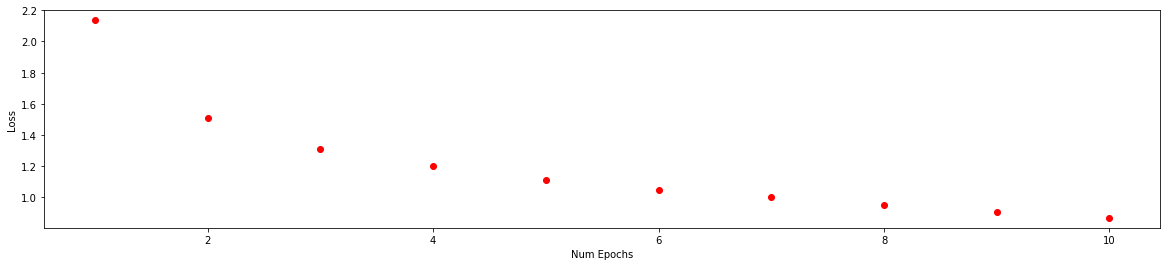

In [33]:
trainLoss = [2.13630, 1.50785, 1.30893, 1.20035, 1.11410, 1.05011, 1.00309, 0.95296, 0.90649, 0.86802]
plt.plot(range(1,11), trainLoss, 'ro')
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.show()

## Additional features

You can implement the following features in your model and check what gives a better accuracy

- [Dropout](http://pytorch.org/docs/master/nn.html#dropout-layers)
- [Non-linear-Activations](http://pytorch.org/docs/master/nn.html#non-linear-activations-weighed-sum-nonlinearity)
- [Max-or-Average-Pooling](http://pytorch.org/docs/master/nn.html#pooling-layers)
- [Normalization](http://pytorch.org/docs/master/nn.html#normalization-layers)
- [Other-Losses](http://pytorch.org/docs/master/nn.html#loss-functions)
- [Optimizers](http://pytorch.org/docs/master/optim.html)

## References

> - https://stackoverflow.com/questions/27469799/plotting-a-signal-in-python
> - https://www.kaggle.com/vinvinvin/high-resolution-mel-spectrograms
> - https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
> - http://www.voiptroubleshooter.com/open_speech/american.html
> - http://recognize-speech.com/preprocessing
> - http://www.dataminingblog.com/standardization-vs-normalization/
> - http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
> - http://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/